In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import umap

In [68]:
sumo = {}
sumo_files = os.listdir('data_experiment1_sumo')
for file in sumo_files:
    sumo_df = pd.read_csv(f'data_experiment1_sumo/{file}')
    sumo_df['gyro_z'] = np.rad2deg(sumo_df['gyro_z'])
    sumo[file.split(".")[0]] = sumo_df
print(sumo.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [69]:
carla = {}
carla_files = os.listdir('data_experiment1_carla')
for file in carla_files:
    carla_df = pd.read_csv(f'data_experiment1_carla/{file}')
    carla_df.rename(columns={'latitude': 'y_pos', 'longitude': 'x_pos'}, inplace=True)
    carla_df['acc_z'] -= 9.8
    carla_df['gyro_z'] = np.rad2deg(carla_df['gyro_z'])
    carla[file.split('.')[0]] = carla_df[carla_df['timestamp'] > 0]
print(carla.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [70]:
carla['veh0_normal'].head()

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,compass,y_pos,x_pos
1,0.1,0.010968,0.000016,0.009995,4.562876e-07,8.283166e-09,-4.472374e-08,329.307134,42.011358,2.099287
2,0.2,0.010968,0.000016,0.009995,-5.355725e-07,-2.302602e-07,5.234671e-08,329.307134,42.011358,2.099287
3,0.3,0.010968,0.000016,0.009995,1.037449e-07,-3.790579e-08,-8.825928e-09,329.307134,42.011358,2.099287
4,0.4,4.352394,0.319496,-0.233655,1.379235e-02,-7.308009e-02,2.466128e+00,329.427373,42.011358,2.099287
5,0.5,8.531729,-0.311816,-0.040391,-7.950380e-03,-4.802523e-04,2.737044e-01,329.420679,42.011359,2.099286


In [71]:
sumo['veh0_normal'].head()

,timestamp,x_pos,y_pos,speed,speed_x,speed_y,acc,acc_x,acc_y,angle,acc_diff,gyro_z
0,0.1,9486.491685,1291.304322,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,314.491672,0.000000,0.000000e+00
1,0.2,9486.490459,1291.305528,0.017197,0.012052,-0.012267,0.171968,0.120516,-0.122674,314.491672,1.719681,-1.460511e-10
2,0.3,9486.486965,1291.308959,0.048966,0.034315,-0.034930,0.317689,0.222638,-0.226624,314.491672,0.317689,0.000000e+00
3,0.4,9486.479461,1291.316332,0.105199,0.073724,-0.075044,0.562335,0.394087,-0.401143,314.491672,2.446460,1.282400e-10
4,0.5,9486.465321,1291.330223,0.198204,0.138903,-0.141389,0.930050,0.651784,-0.663454,314.491672,3.677155,-1.460511e-10


The time series may have different lengths because of the routing and simulation of each simulator.

In [72]:
for (sumo_k, sumo_v), (carla_k, carla_v) in zip(sumo.items(), carla.items()):
    print(f'Sumo {sumo_k} size: {len(sumo_v)}. Carla {sumo_k} size: {len(carla_v)}')


Sumo veh1_aggressive size: 4534. Carla veh1_aggressive size: 3316
Sumo veh0_normal size: 5039. Carla veh0_normal size: 4106


Note que gyro_z não é obtido diretamente pelo SUMO, aqui está sendo realizada uma aproximação a partir da variação nos ângulos

In [73]:
def plot_df(sumo_df=None, carla_df=None, idx="", uah_df_imu=None, uah_df_gnss=None, save_path=None):
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    if sumo_df is not None:
        axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha)
    if carla_df is not None:
        axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    if uah_df_imu is not None:
        axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    if sumo_df is not None:
        axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha)
    if carla_df is not None:
        axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    if uah_df_imu is not None:
        axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    if sumo_df is not None:
        axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha)
    if carla_df is not None:
        axes[2].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    axes_count = 3
    # Plot angle
    if uah_df_gnss is None:
        if sumo_df is not None:
            axes[axes_count].plot(sumo_df['timestamp'], sumo_df['angle'], label='Sumo Angle', alpha=alpha)
        if carla_df is not None:
            axes[axes_count].plot(carla_df['timestamp'], carla_df['compass'], label='Carla Angle', alpha=alpha)
        if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
            axes[axes_count].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
        axes[axes_count].set_title("Angle over Time")
        axes[axes_count].set_ylabel("Angle (rad)")
        axes[axes_count].legend()
        axes[axes_count].grid(True)
        axes_count += 1

    # Plot Sumo position
    if sumo_df is not None:
        scatter = axes[axes_count].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10, label='Sumo')
        axes[axes_count].set_title("Sumo Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot Carla position
    if carla_df is not None:
        scatter = axes[axes_count].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10, label='Carla')
        axes[axes_count].set_title("Carla Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot UAH position if available
    if uah_df_gnss is not None and 'lat' in uah_df_gnss.columns and 'lon' in uah_df_gnss.columns and 'timestamp' in uah_df_gnss.columns:
        scatter = axes[axes_count].scatter(uah_df_gnss['lon'], uah_df_gnss['lat'], c=uah_df_gnss['timestamp'], cmap='viridis', s=10, label='UAH', alpha=0.7)
        axes[axes_count].set_title("UAH Position over Time")
        axes[axes_count].set_xlabel("Longitude")
        axes[axes_count].set_ylabel("Latitude")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Remove unused axes if any
    if axes_count < 8:
        for i in range(axes_count, 8):
            fig.delaxes(axes[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])

    if uah_df_imu is not None:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'Comparison of CARLA and UAH Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'UAH Data for {idx}', fontsize=18)
    else:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and CARLA Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'CARLA Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'SUMO Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'No data available for {idx}', fontsize=18)
    
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [74]:
def plot_histograms(sumo_df, carla_df, idx, uah_df_imu = None, bins=50, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=bins, alpha=0.5, label='Sumo Acc X', density=True, color='blue')
    axes[0].hist(carla_df['acc_x'], bins=bins, alpha=0.5, label='Carla Acc X', density=True, color='orange')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color='blue')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='orange')
    if uah_df_imu is not None and 'acc_x' in uah_df_imu.columns:
        axes[0].hist(uah_df_imu['acc_x'], bins=bins, alpha=0.5, label='UAH Acc X', density=True, color='green')
        uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=bins, alpha=0.5, label='Sumo Acc Y', density=True, color='blue')
    axes[1].hist(carla_df['acc_y'], bins=bins, alpha=0.5, label='Carla Acc Y', density=True, color='orange')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color='blue')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='orange')
    if uah_df_imu is not None and 'acc_y' in uah_df_imu.columns:
        axes[1].hist(uah_df_imu['acc_y'], bins=bins, alpha=0.5, label='UAH Acc Y', density=True, color='green')
        uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=bins, alpha=0.5, label='Sumo Gyro Z', density=True, color='blue')
    axes[2].hist(carla_df['gyro_z'], bins=bins, alpha=0.5, label='Carla Gyro Z', density=True, color='orange')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color='blue')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Carla Gyro Z KDE', color='orange')
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].hist(uah_df_imu['Yaw'], bins=bins, alpha=0.5, label='UAH Yaw', density=True, color='green')
        uah_df_imu['Yaw'].plot(kind='kde', ax=axes[2], label='UAH Yaw KDE', color='green')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Plot angle
    axes[3].hist(sumo_df['angle'], bins=bins, alpha=0.5, label='Sumo Angle', density=True, color='blue')
    axes[3].hist(carla_df['compass'], bins=bins, alpha=0.5, label='Carla Angle', density=True, color='orange')
    sumo_df['angle'].plot(kind='kde', ax=axes[3], label='Sumo Angle KDE', color='blue')
    carla_df['compass'].plot(kind='kde', ax=axes[3], label='Carla Angle KDE', color='orange')
    axes[3].set_title("Angle Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Set the main title
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


## UAH-Driveset

In [75]:
def getData(driver, specifier, sensor):

    if sensor == 'acc':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_ACCELEROMETERS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'system_active',
                    'acc_x',
                    'acc_y',
                    'acc_z',
                    'acc_x_KF',
                    'acc_y_KF',
                    'acc_z_KF',
                    'Roll',
                    'Pitch',
                    'Yaw'
                ], usecols=range(11))
                data = data.drop(['system_active'], axis=1)
                data['acc'] = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
                return data
            
    elif sensor == 'gps':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_GPS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'speed',
                    'lat',
                    'lon',
                    'altitude',
                    'vert_accuracy',
                    'horiz_accuracy',
                    'course',
                    'difcourse',
                ], usecols=range(9))
                return data

In [76]:
def read_gps(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='gps')], axis=0)
        # normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='gps')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='gps')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='gps')], axis=0)

    df_gps = {}
    df_gps['normal'] = normal
    df_gps['aggressive'] = aggressive
    df_gps['drowsy'] = drowsy

    return df_gps

In [77]:
def read_accelerometer(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='acc')], axis=0)
        # normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='acc')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='acc')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='acc')], axis=0)

    df_accelerometer = {}
    df_accelerometer['normal'] = normal
    df_accelerometer['aggressive'] = aggressive
    df_accelerometer['drowsy'] = drowsy

    return df_accelerometer

Reading from only one driver and one run to be able to compare

In [78]:
drivers = ['D1']

In [79]:
df_acc = read_accelerometer(drivers)
df_gps = read_gps(drivers)

In [80]:
df_gps['normal']

,timestamp,speed,lat,lon,altitude,vert_accuracy,horiz_accuracy,course,difcourse
0,7.85,65.2,40.512787,-3.404477,612.7,4,5,331.9,0.000
1,8.83,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000
2,9.82,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055
3,10.80,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055
4,11.80,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703
...,...,...,...,...,...,...,...,...,...
619,626.80,92.0,40.584282,-3.552518,610.6,6,5,282.3,3.164
620,627.82,90.8,40.584324,-3.552810,610.2,6,5,281.2,2.812
621,628.82,89.7,40.584354,-3.553110,610.0,6,5,279.8,2.461
622,629.82,88.7,40.584393,-3.553401,609.7,6,5,278.4,2.812


In [81]:
df_acc['normal'] = df_acc['normal'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})
df_acc['aggressive'] = df_acc['aggressive'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})

In [82]:
df_acc['normal'].head()

,timestamp,acc_z,acc_y,acc_x,acc_x_KF,acc_y_KF,acc_z_KF,Roll,Pitch,gyro_z,acc
0,6.94,0.017,-0.011,0.018,-0.005,0.008,0.018,-1.523,0.015,0.012,0.027092
1,7.03,0.046,0.007,0.019,0.016,-0.002,0.018,-1.522,0.012,0.012,0.050259
2,7.14,0.052,-0.016,0.027,0.037,-0.005,0.018,-1.520,0.014,0.011,0.060737
3,7.24,0.015,-0.016,0.026,0.038,-0.009,0.024,-1.523,0.014,0.011,0.034015
4,7.34,-0.014,-0.017,0.040,0.012,-0.016,0.032,-1.525,0.012,0.011,0.045662


Simulated only up to lat, lon = 40.554174, -3.497402 because of simulation problems. Let's trim the dataset in this position

In [83]:
def trim_gnss(df_gnss, df_acc, lat, lon, lat_margin=0.001, lon_margin=0.001):

    # Define bounds
    lat_min = lat - lat_margin
    lat_max = lat + lat_margin
    lon_min = lon - lon_margin
    lon_max = lon + lon_margin

    # Find the first index within the interval
    condition = (
        (df_gnss['lat'] >= lat_min) & (df_gnss['lat'] <= lat_max) &
        (df_gnss['lon'] >= lon_min) & (df_gnss['lon'] <= lon_max)
    )

    # Get the first matching index
    matching_indices = df_gnss.index[condition]

    if not matching_indices.empty:
        timestamp = df_gnss['timestamp'].iloc[matching_indices[0]]
        closest_idx = matching_indices[0]
        print(f"Trimming GNSS data to timestamp: {timestamp}")
        gnss_trimmed = df_gnss.loc[closest_idx:].copy()
        print(f"Trimming accelerometer data to timestamp: {timestamp}")
        acc_trimmed = df_acc[df_acc['timestamp'] >= timestamp]
        acc_trimmed['timestamp'] -= timestamp
        gnss_trimmed['timestamp'] -= timestamp
        return gnss_trimmed, acc_trimmed

    else:
        raise ValueError("No matching GNSS data found within the specified bounds.")

In [84]:
max_lat, max_lon = 40.534921, -3.468994
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps['normal'], df_acc['normal'] = trim_gnss(df_gps['normal'], df_acc['normal'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)
df_gps['aggressive'], df_acc['aggressive'] = trim_gnss(df_gps['aggressive'], df_acc['aggressive'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)

Trimming GNSS data to timestamp: 258.83
Trimming accelerometer data to timestamp: 258.83
Trimming GNSS data to timestamp: 200.19
Trimming accelerometer data to timestamp: 200.19


/tmp/ipykernel_12137/489965173.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_trimmed['timestamp'] -= timestamp


In [85]:
mean_normal = df_gps['normal']['speed'].mean()
max_normal = df_gps['normal']['speed'].max()
mean_aggressive = df_gps['aggressive']['speed'].mean()
max_aggressive = df_gps['aggressive']['speed'].max()

print(f"Normal:    Mean speed = {mean_normal:.2f} km/h, Max speed = {max_normal:.2f} km/h")
print(f"Aggressive: Mean speed = {mean_aggressive:.2f} km/h, Max speed = {max_aggressive:.2f} km/h")

# Convert to m/s (1 km/h = 0.27778 m/s)
mean_normal_ms = mean_normal * 0.27778
max_normal_ms = max_normal * 0.27778
mean_aggressive_ms = mean_aggressive * 0.27778
max_aggressive_ms = max_aggressive * 0.27778

print(f"Normal:    Mean speed = {mean_normal_ms:.2f} m/s, Max speed = {max_normal_ms:.2f} m/s")
print(f"Aggressive: Mean speed = {mean_aggressive_ms:.2f} m/s, Max speed = {max_aggressive_ms:.2f} m/s")


Normal:    Mean speed = 98.60 km/h, Max speed = 114.90 km/h
Aggressive: Mean speed = 111.36 km/h, Max speed = 132.70 km/h
Normal:    Mean speed = 27.39 m/s, Max speed = 31.92 m/s
Aggressive: Mean speed = 30.93 m/s, Max speed = 36.86 m/s


In [86]:
# Getting a second real driver to compare with
df_acc_2 = read_accelerometer(['D3'])
df_gps_2 = read_gps(['D3'])
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps_2['normal'], df_acc_2['normal'] = trim_gnss(df_gps_2['normal'], df_acc_2['normal'], max_lat, max_lon, lat_margin=0.0005, lon_margin=0.0005)
df_gps_2['aggressive'], df_acc_2['aggressive'] = trim_gnss(df_gps_2['aggressive'], df_acc_2['aggressive'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)

Trimming GNSS data to timestamp: 261.93
Trimming accelerometer data to timestamp: 261.93
Trimming GNSS data to timestamp: 236.91
Trimming accelerometer data to timestamp: 236.91


/tmp/ipykernel_12137/489965173.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_trimmed['timestamp'] -= timestamp


In [87]:
df_acc_2['normal'] = df_acc_2['normal'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})
df_acc_2['aggressive'] = df_acc_2['aggressive'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})

In [88]:
def plot_gps(df_gps, sumo_df=None, carla_df=None):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot UAH GPS
    axes[0].scatter(df_gps['lon'], df_gps['lat'], c=df_gps['timestamp'], cmap='viridis', s=10)
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].set_title("UAH Position")
    cbar0 = fig.colorbar(axes[0].collections[0], ax=axes[0])
    cbar0.set_label("Time (s)")
    axes[0].grid(True)

    # Plot SUMO
    if sumo_df is not None:
        axes[1].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10)
        axes[1].set_xlabel("X position")
        axes[1].set_ylabel("Y position")
        axes[1].set_title("SUMO Position")
        cbar1 = fig.colorbar(axes[1].collections[0], ax=axes[1])
        cbar1.set_label("Time (s)")
        axes[1].grid(True)

    # Plot CARLA
    if carla_df is not None:
        axes[2].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10)
        axes[2].set_xlabel("X position")
        axes[2].set_ylabel("Y position")
        axes[2].set_title("CARLA Position")
        cbar2 = fig.colorbar(axes[2].collections[0], ax=axes[2])
        cbar2.set_label("Time (s)")
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()

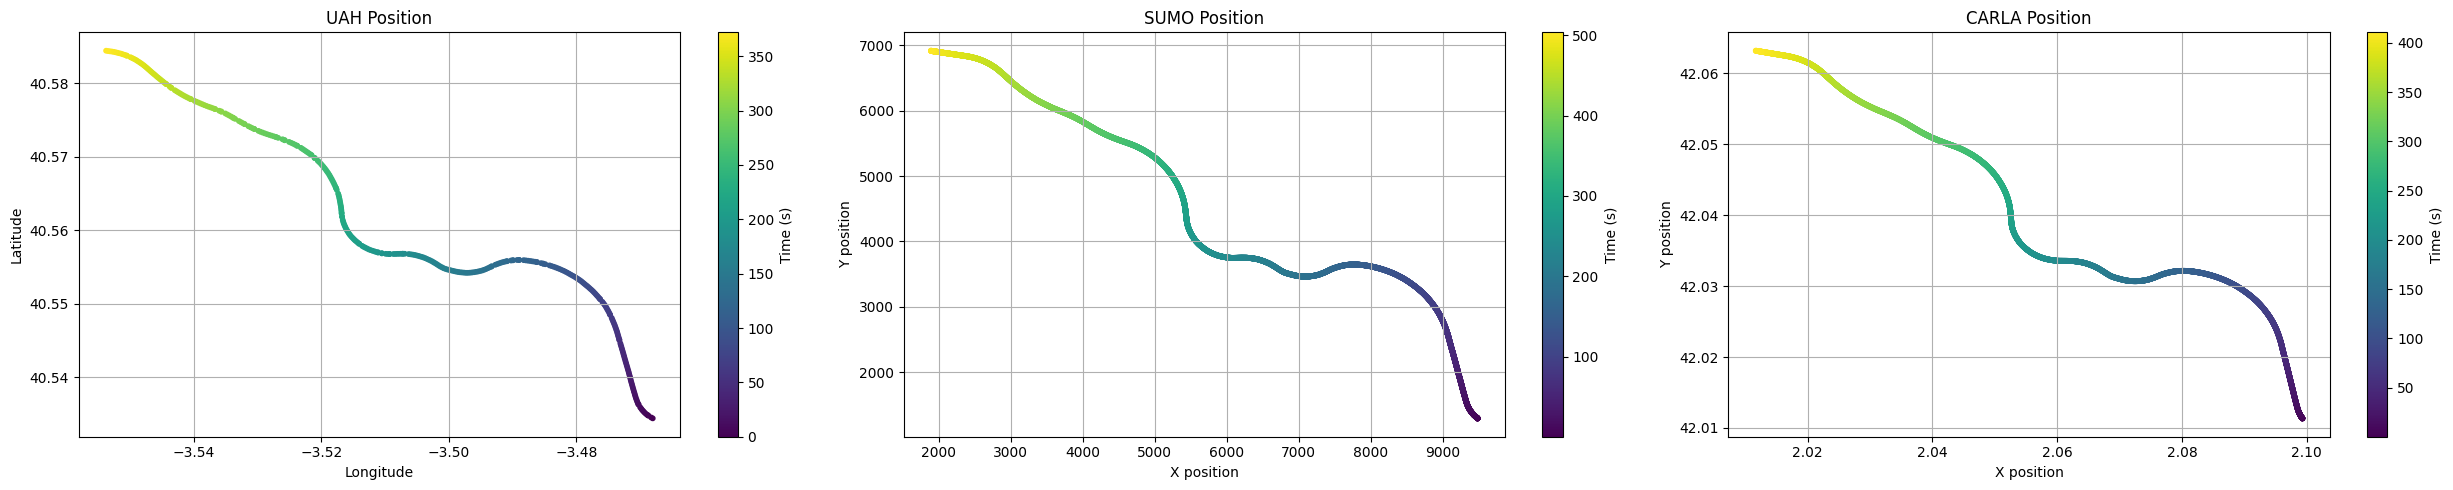

In [89]:
plot_gps(df_gps['normal'], sumo['veh0_normal'], carla['veh0_normal'])  

In [90]:
def plot_sumo_uah(sumo_df, uah_df_gnss, uah_df_imu, idx, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha, color='darkgoldenrod')
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha, color='darkgoldenrod')
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha, color='darkgoldenrod')
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['gyro_z'], label='UAH Gyro Z', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    
    fig.suptitle(f'Comparison of SUMO and UAH Data data for {idx.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [50]:
def plot_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot acceleration Z
    axes[2].plot(carla_df['timestamp'], carla_df['acc_z'], label='Carla Acc Z', alpha=alpha)
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['acc_z'], label='UAH Acc Z', color='red', alpha=0.7)
    axes[2].set_title("Acceleration Z over Time")
    axes[2].set_ylabel("Acceleration (m/s²)")
    axes[2].legend()
    axes[2].grid(True)

    # Plot gyroscope X
    axes[3].plot(carla_df['timestamp'], carla_df['gyro_x'], label='Carla Gyro X', alpha=alpha)
    axes[3].plot(uah_df_imu['timestamp'], uah_df_imu['Roll'], label='UAH Roll', color='red', alpha=0.7)
    axes[3].set_title("Gyroscope X over Time")
    axes[3].set_ylabel("Angular Velocity (rad/s)")
    axes[3].legend()
    axes[3].grid(True)

    # Plot gyroscope Y
    axes[4].plot(carla_df['timestamp'], carla_df['gyro_y'], label='Carla Gyro Y', alpha=alpha)
    axes[4].plot(uah_df_imu['timestamp'], uah_df_imu['Pitch'], label='UAH Pitch', color='red', alpha=0.7)
    axes[4].set_title("Gyroscope Y over Time")
    axes[4].set_ylabel("Angular Velocity (rad/s)")
    axes[4].legend()
    axes[4].grid(True)

    # Plot gyroscope Z
    axes[5].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    axes[5].plot(uah_df_imu['timestamp'], uah_df_imu['gyro_z'], label='UAH Gyro Z', color='red', alpha=0.7)
    axes[5].set_title("Gyroscope Z over Time")
    axes[5].set_ylabel("Angular Velocity (rad/s)")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [91]:
def plot_uah_uah(uah_imu1, uah_imu2, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    uah_imu1 = uah_imu1.rename(columns={'gyro_x': 'Roll', 'gyro_y': 'Pitch', 'gyro_z': 'Yaw'})
    uah_imu2 = uah_imu2.rename(columns={'gyro_x': 'Roll', 'gyro_y': 'Pitch', 'gyro_z': 'Yaw'})

    # Plot acceleration X
    axes[0].plot(uah_imu1['timestamp'], uah_imu1['acc_x'], label='UAH_D1 Acc X', alpha=alpha, color='red')
    axes[0].plot(uah_imu2['timestamp'], uah_imu2['acc_x'], label='UAH_D2 Acc X', color='green', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(uah_imu1['timestamp'], uah_imu1['acc_y'], label='UAH_D1 Acc Y', alpha=alpha, color='red')
    axes[1].plot(uah_imu2['timestamp'], uah_imu2['acc_y'], label='UAH_D2 Acc Y', color='green', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot acceleration Z
    axes[2].plot(uah_imu1['timestamp'], uah_imu1['acc_z'], label='UAH_D1 Acc Z', alpha=alpha, color='red')
    axes[2].plot(uah_imu2['timestamp'], uah_imu2['acc_z'], label='UAH_D2 Acc Z', color='green', alpha=0.7)
    axes[2].set_title("Acceleration Z over Time")
    axes[2].set_ylabel("Acceleration (m/s²)")
    axes[2].legend()
    axes[2].grid(True)

    # Plot gyroscope X
    axes[3].plot(uah_imu1['timestamp'], uah_imu1['Roll'], label='UAH_D1 Roll', alpha=alpha, color='red')
    axes[3].plot(uah_imu2['timestamp'], uah_imu2['Roll'], label='UAH_D2 Roll', color='green', alpha=0.7)
    axes[3].set_title("Gyroscope X over Time")
    axes[3].set_ylabel("Angular Velocity (rad/s)")
    axes[3].legend()
    axes[3].grid(True)

    # Plot gyroscope Y
    axes[4].plot(uah_imu1['timestamp'], uah_imu1['Pitch'], label='UAH_D1 Pitch', alpha=alpha, color='red')
    axes[4].plot(uah_imu2['timestamp'], uah_imu2['Pitch'], label='UAH_D2 Pitch', color='green', alpha=0.7)
    axes[4].set_title("Gyroscope Y over Time")
    axes[4].set_ylabel("Angular Velocity (rad/s)")
    axes[4].legend()
    axes[4].grid(True)

    # Plot gyroscope Z
    axes[5].plot(uah_imu1['timestamp'], uah_imu1['Yaw'], label='UAH_D1 Yaw', alpha=alpha, color='red')
    axes[5].plot(uah_imu2['timestamp'], uah_imu2['Yaw'], label='UAH_D2 Yaw', color='green', alpha=0.7)
    axes[5].set_title("Gyroscope Z over Time")
    axes[5].set_ylabel("Angular Velocity (rad/s)")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of UAH for driver 1 and driver 2', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [124]:
def hist_sumo_uah(sumo_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=50, alpha=0.5, label='Sumo Acc X', density=True, color='blue')
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='green')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color='blue')
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=50, alpha=0.5, label='Sumo Acc Y', density=True, color='blue')
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='green')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color='blue')
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=50, alpha=0.5, label='Sumo Gyro Z', density=True, color='blue')
    axes[2].hist(uah_df_imu['gyro_z'], bins=50, alpha=0.5, label='UAH Gyro Z', density=True, color='green')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color='blue')
    uah_df_imu['gyro_z'].plot(kind='kde', ax=axes[2], label='UAH Gyro Z KDE', color='green')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of SUMO and UAH Data for {veh.split("_")[-1]} vehicle', fontsize=16)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [128]:
def hist_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Acceleration X histogram
    axes[0].hist(carla_df['acc_x'], bins=50, alpha=0.5, label='Carla Acc X', density=True, color='blue')
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='green')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='blue')
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Acceleration Y histogram
    axes[1].hist(carla_df['acc_y'], bins=50, alpha=0.5, label='Carla Acc Y', density=True, color='blue')
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='green')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='blue')
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Acceleration Z histogram
    axes[2].hist(carla_df['acc_z'], bins=50, alpha=0.5, label='Carla Acc Z', density=True, color='blue')
    axes[2].hist(uah_df_imu['acc_z'], bins=50, alpha=0.5, label='UAH Acc Z', density=True, color='green')
    carla_df['acc_z'].plot(kind='kde', ax=axes[2], label='Carla Acc Z KDE', color='blue')
    uah_df_imu['acc_z'].plot(kind='kde', ax=axes[2], label='UAH Acc Z KDE', color='green')
    axes[2].set_title("Acceleration Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Gyroscope X histogram
    axes[3].hist(carla_df['gyro_x'], bins=50, alpha=0.5, label='Carla Gyro X', density=True, color='blue')
    axes[3].hist(uah_df_imu['Roll'], bins=50, alpha=0.5, label='UAH Roll', density=True, color='green')
    carla_df['gyro_x'].plot(kind='kde', ax=axes[3], label='Carla Gyro X KDE', color='blue')
    uah_df_imu['Roll'].plot(kind='kde', ax=axes[3], label='UAH Roll KDE', color='green')
    axes[3].set_title("Gyroscope X Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Gyroscope Y histogram
    axes[4].hist(carla_df['gyro_y'], bins=50, alpha=0.5, label='Carla Gyro Y', density=True, color='blue')
    axes[4].hist(uah_df_imu['Pitch'], bins=50, alpha=0.5, label='UAH Pitch', density=True, color='green')
    carla_df['gyro_y'].plot(kind='kde', ax=axes[4], label='Carla Gyro Y KDE', color='blue')
    uah_df_imu['Pitch'].plot(kind='kde', ax=axes[4], label='UAH Pitch KDE', color='green')
    axes[4].set_title("Gyroscope Y Histogram")
    axes[4].set_ylabel("Density")
    axes[4].legend()
    axes[4].grid(True)

    # Gyroscope Z histogram
    axes[5].hist(carla_df['gyro_z'], bins=50, alpha=0.5, label='Carla Gyro Z', density=True, color='blue')
    axes[5].hist(uah_df_imu['gyro_z'], bins=50, alpha=0.5, label='UAH Gyro Z', density=True, color='green')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[5], label='Carla Gyro Z KDE', color='blue')
    uah_df_imu['gyro_z'].plot(kind='kde', ax=axes[5], label='UAH Gyro Z KDE', color='green')
    axes[5].set_title("Gyroscope Z Histogram")
    axes[5].set_ylabel("Density")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [129]:
os.makedirs('plots_hist', exist_ok=True)
os.makedirs('plots_uah', exist_ok=True)
for id in carla.keys():
    if id.split('_')[1] == 'normal':
        plot_carla_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_uah/carla_{id}.png')
        hist_carla_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_hist/carla_{id}.png')
    else:
        plot_carla_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_uah/carla_{id}.png')
        hist_carla_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_hist/carla_{id}.png')

In [125]:
for id in sumo.keys():
    if id.split('_')[1] == 'normal':
        plot_sumo_uah(sumo[id], uah_df_gnss=df_gps['normal'], uah_df_imu=df_acc['normal'], idx=id, save_path=f'plots_uah/sumo_{id}.png')
        hist_sumo_uah(sumo[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], veh=id, save_path=f'plots_hist/sumo_{id}.png')
    else:
        plot_sumo_uah(sumo[id], uah_df_gnss=df_gps['aggressive'], uah_df_imu=df_acc['aggressive'], idx=id, save_path=f'plots_uah/sumo_{id}.png')
        hist_sumo_uah(sumo[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], veh=id, save_path=f'plots_hist/sumo_{id}.png')

In [96]:
for beh in ['normal', 'aggressive']:
    plot_uah_uah(uah_imu1=df_acc[beh], uah_imu2=df_acc_2[beh], save_path=f'plots_uah/uah_uah_{beh}.png')

# Comparison Metrics

In [134]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

In [135]:
def compare_distributions(carla_data, sumo_data, bins=100):
    # Define common bin edges
    min_val = min(carla_data.min(), sumo_data.min())
    max_val = max(carla_data.max(), sumo_data.max())
    hist_bins = np.linspace(min_val, max_val, bins + 1)

    # Histogram with density=True to approximate PDFs
    carla_hist, _ = np.histogram(carla_data, bins=hist_bins, density=True)
    sumo_hist, _ = np.histogram(sumo_data, bins=hist_bins, density=True)

    # Avoid zero entries to prevent divide-by-zero in KL
    carla_hist += 1e-10
    sumo_hist += 1e-10

    # Normalize (just in case)
    carla_hist /= carla_hist.sum()
    sumo_hist /= sumo_hist.sum()

    # KL Divergence (not symmetric)
    kl_div = entropy(carla_hist, sumo_hist)

    # Jensen-Shannon Distance (symmetric and bounded)
    js_dist = jensenshannon(carla_hist, sumo_hist)

    # Wasserstein Distance (Earth Mover’s Distance)
    wasser_dist = wasserstein_distance(carla_data, sumo_data)

    # Kolmogorov–Smirnov Test (returns D-statistic and p-value)
    ks_stat, ks_pval = ks_2samp(carla_data, sumo_data)

    # Define which metrics are "bigger is better" (↑) or "smaller is better" (↓)
    # For these metrics, smaller is better: KL, JS, Wasserstein, KS Statistic
    # For KS p-value, bigger is better
    return {
        "KL Divergence ↓": kl_div,
        "Jensen-Shannon Distance ↓": js_dist,
        "Wasserstein Distance ↓": wasser_dist,
        "KS Statistic ↓": ks_stat,
        "KS p-value ↑": ks_pval
    }

In [136]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_carla_sumo = {}
for id in carla.keys():
    beh = id.split('_')[1]
    
    metrics_carla_sumo[beh] = {}
    for sensor in sensors:
        metrics_carla_sumo[beh][sensor] = compare_distributions(carla[id][sensor], sumo[id][sensor])

In [137]:
sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_carla_uah[beh] = {}
    for sensor in sensors:
        metrics_carla_uah[beh][sensor] = compare_distributions(carla[id][sensor], uah[sensor])

In [138]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_sumo_uah[beh] = {}
    for sensor in sensors:
        metrics_sumo_uah[beh][sensor] = compare_distributions(sumo[id][sensor], uah[sensor])

In [139]:

sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1 = df_acc[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
    uah_2 = df_acc_2[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})

    metrics_uah_uah[id] = {}
    for sensor in sensors:
        metrics_uah_uah[id][sensor] = compare_distributions(uah_1[sensor], uah_2[sensor])

In [111]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['normal']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['aggressive']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['normal']).T
display(metrics_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['aggressive']).T
display(metrics_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['normal']).T
display(metrics_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['aggressive']).T
display(metrics_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['normal']).T
display(metrics_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['aggressive']).T
display(metrics_uah_uah_df)


Metrics for CARLA vs SUMO (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,4.066293,0.600232,0.276759,0.429280,3.448578e-321
acc_y,2.697024,0.573136,0.567093,0.403464,5.044410e-321
gyro_z,2.128778,0.635493,3.277711,0.445588,2.411040e-321


Metrics for CARLA vs SUMO (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.721992,0.286735,0.120949,0.355509,1.696270e-215
acc_y,2.260326,0.451602,0.765368,0.414722,1.423470e-295
gyro_z,1.432522,0.489771,2.030952,0.463859,3.858653e-321


Metrics for CARLA vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,16.865012,0.707771,0.336157,0.522745,0.000000e+00
acc_y,15.940183,0.687576,0.648723,0.467844,3.804305e-322
acc_z,0.609008,0.410088,0.022599,0.407496,1.074545e-288
gyro_x,25.051205,0.832555,1.550912,1.000000,0.000000e+00
gyro_y,1.933042,0.679422,0.036256,0.556020,0.000000e+00
gyro_z,14.303722,0.640492,3.914681,0.504140,0.000000e+00


Metrics for CARLA vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,3.658647,0.401235,0.184025,0.542071,0.000000e+00
acc_y,11.906253,0.514549,0.856958,0.477429,0.000000e+00
acc_z,1.057837,0.512205,0.032776,0.499124,0.000000e+00
gyro_x,25.470569,0.832555,1.560672,1.000000,0.000000e+00
gyro_y,2.266628,0.701744,0.049946,0.461893,1.718854e-320
gyro_z,10.707093,0.519441,2.998382,0.546446,0.000000e+00


Metrics for SUMO vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,2.642584,0.350177,0.059483,0.229498,1.201616e-98
acc_y,1.438299,0.293793,0.081694,0.182535,2.284877e-62
gyro_z,2.966113,0.620274,1.821181,0.935106,0.000000e+00


Metrics for SUMO vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,1.361054,0.299565,0.064564,0.211333,1.571381e-75
acc_y,1.336686,0.280300,0.091895,0.174349,1.979926e-51
gyro_z,5.086040,0.780930,2.642329,0.933833,0.000000e+00


Metrics for UAH (driver 1) vs UAH (driver 2) (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.106855,0.102154,0.001652,0.040309,2.885231e-03
acc_y,0.368457,0.135086,0.007016,0.067895,1.799492e-08
acc_z,0.065656,0.074965,0.001208,0.026744,1.114784e-01
gyro_x,0.161828,0.189857,0.006728,0.127722,6.534911e-29
gyro_y,0.542791,0.254399,0.015522,0.210986,1.766274e-78
gyro_z,8.154651,0.607103,0.437475,0.443096,2.974275e-321


Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.248280,0.136911,0.005595,0.079995,4.934534e-11
acc_y,0.420981,0.144754,0.007944,0.058063,5.120794e-06
acc_z,0.247836,0.143589,0.009523,0.077118,2.767116e-10
gyro_x,0.344048,0.262815,0.014161,0.187843,4.150848e-59
gyro_y,3.380582,0.384042,0.032045,0.218836,3.134183e-80
gyro_z,12.951288,0.660210,0.754848,0.551817,0.000000e+00


In [140]:
import seaborn as sns

In [141]:
def plot_divergence(metrics_sumo, metrics_carla, metrics_uah, statistic = 'KL Divergence ↓'):
    plt.figure(figsize=(12, 6))

    # Prepare DataFrames
    normal_sumo = pd.DataFrame(metrics_sumo['normal']).T
    normal_carla = pd.DataFrame(metrics_carla['normal']).drop(columns=['gyro_x', 'gyro_y'], errors='ignore').T
    normal_uah = pd.DataFrame(metrics_uah['normal']).T

    aggressive_sumo = pd.DataFrame(metrics_sumo['aggressive']).T
    aggressive_carla = pd.DataFrame(metrics_carla['aggressive']).drop(columns=['gyro_x', 'gyro_y'], errors='ignore').T
    aggressive_uah = pd.DataFrame(metrics_uah['aggressive']).T

    # All sensors present in any
    all_sensors = normal_sumo.index.union(normal_carla.index).union(normal_uah.index)
    x = np.arange(len(all_sensors)) * 1.5

    # KL values for each
    carla_kl = normal_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl = normal_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl = normal_uah.reindex(all_sensors)[statistic].fillna(0)

    carla_kl_agg = aggressive_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl_agg = aggressive_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl_agg = aggressive_uah.reindex(all_sensors)[statistic].fillna(0)

    n_bars = 6  # carla normal, sumo normal, uah normal, carla agg, sumo agg, uah agg
    width = 0.2

    plt.bar(x - 2.5*width, carla_kl, width=width, label='CARLA normal', color=sns.color_palette('viridis', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 1.5*width, carla_kl_agg, width=width, label='CARLA aggressive', color=sns.color_palette('magma', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 0.5*width, sumo_kl, width=width, label='SUMO normal', color=sns.color_palette('viridis', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 0.5*width, sumo_kl_agg, width=width, label='SUMO aggressive', color=sns.color_palette('magma', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 1.5*width, uah_kl, width=width, label='UAH (driver 2) normal', color=sns.color_palette('viridis', n_colors=3)[2], alpha=0.7)
    plt.bar(x + 2.5*width, uah_kl_agg, width=width, label='UAH (driver 2) aggressive', color=sns.color_palette('magma', n_colors=3)[2], alpha=0.7)

    plt.xticks(x, all_sensors)
    plt.legend()
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence for CARLA, SUMO, and UAH (driver 2) vs UAH (driver 1)')
    plt.xlabel('Sensor')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [151]:
def plot_divergence_less(metrics_sumo, metrics_carla, metrics_uah, statistic='KL Divergence ↓'):
    plt.figure(figsize=(10, 5))

    # Prepare DataFrames
    normal_sumo = pd.DataFrame(metrics_sumo['normal']).T
    normal_carla = pd.DataFrame(metrics_carla['normal']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T
    normal_uah = pd.DataFrame(metrics_uah['normal']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T

    aggressive_sumo = pd.DataFrame(metrics_sumo['aggressive']).T
    aggressive_carla = pd.DataFrame(metrics_carla['aggressive']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T
    aggressive_uah = pd.DataFrame(metrics_uah['aggressive']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T

    # Only keep acc_x, acc_y, gyro_z
    keep_sensors = ['acc_x', 'acc_y', 'gyro_z']
    all_sensors = [s for s in keep_sensors if s in normal_sumo.index or s in normal_carla.index or s in normal_uah.index]
    x = np.arange(len(all_sensors)) * 1.5

    # KL values for each
    carla_kl = normal_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl = normal_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl = normal_uah.reindex(all_sensors)[statistic].fillna(0)

    carla_kl_agg = aggressive_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl_agg = aggressive_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl_agg = aggressive_uah.reindex(all_sensors)[statistic].fillna(0)

    width = 0.2

    plt.bar(x - 2.5*width, carla_kl, width=width, label='CARLA normal', color=sns.color_palette('viridis', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 1.5*width, carla_kl_agg, width=width, label='CARLA aggressive', color=sns.color_palette('magma', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 0.5*width, sumo_kl, width=width, label='SUMO normal', color=sns.color_palette('viridis', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 0.5*width, sumo_kl_agg, width=width, label='SUMO aggressive', color=sns.color_palette('magma', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 1.5*width, uah_kl, width=width, label='UAH (driver 2) normal', color=sns.color_palette('viridis', n_colors=3)[2], alpha=0.7)
    plt.bar(x + 2.5*width, uah_kl_agg, width=width, label='UAH (driver 2) aggressive', color=sns.color_palette('magma', n_colors=3)[2], alpha=0.7)

    plt.xticks(x, all_sensors)
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence for CARLA, SUMO, and UAH (driver 2) vs UAH (driver 1)')
    plt.xlabel('Sensor')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

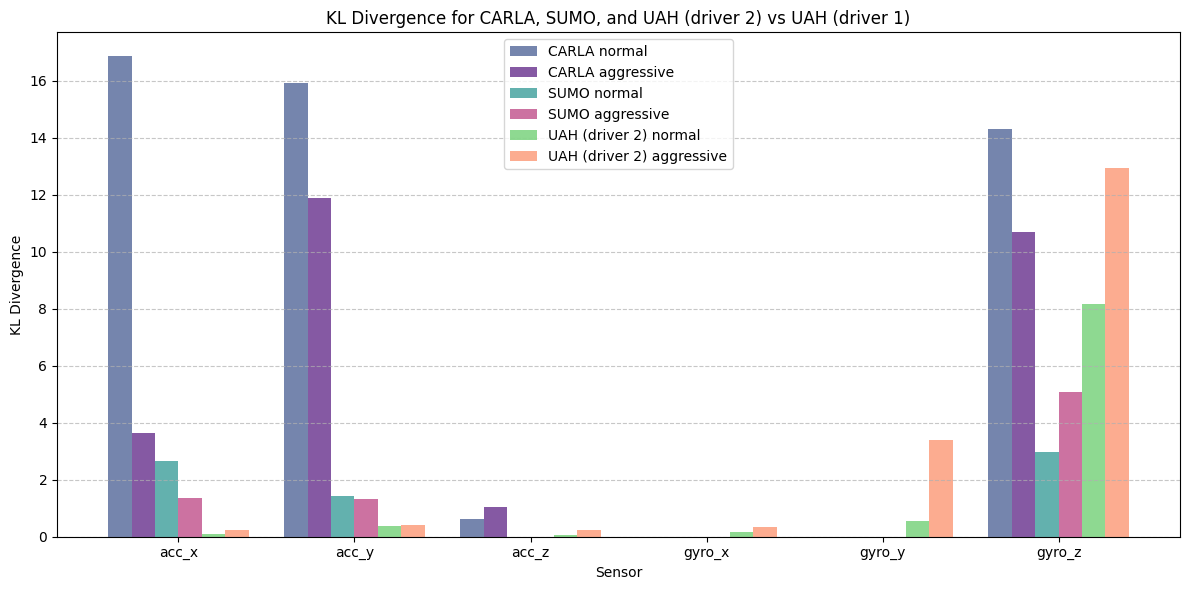

In [143]:
plot_divergence(metrics_sumo_uah, metrics_carla_uah, metrics_uah_uah)

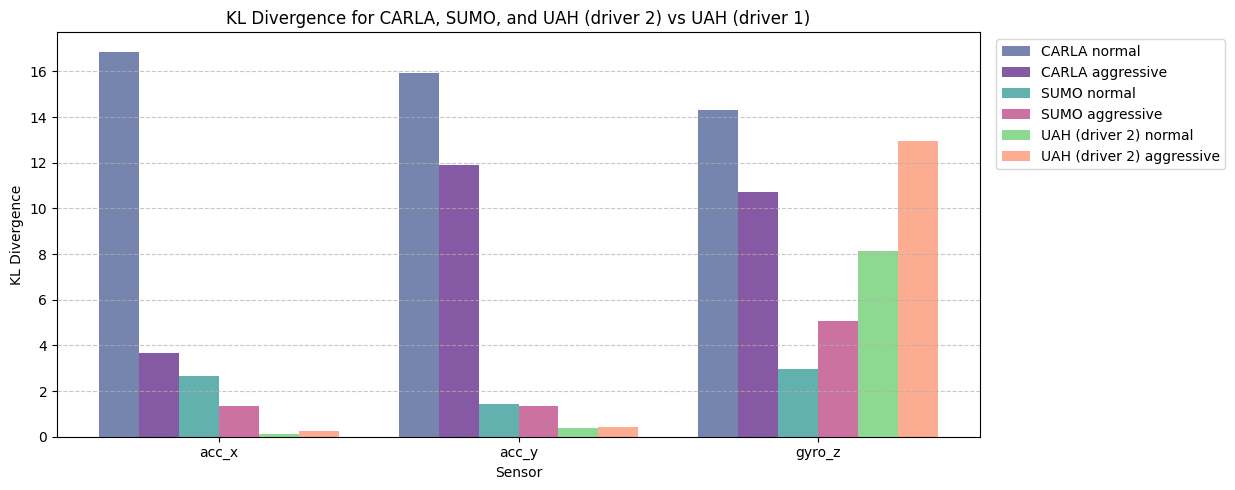

In [152]:
plot_divergence_less(metrics_sumo_uah, metrics_carla_uah, metrics_uah_uah)

In [117]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde, energy_distance
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist, pdist
# Optional: fix random seed for reproducibility
np.random.seed(42)

In [118]:
def multivariate_energy_distance(X, Y):
    # pairwise distances between X and Y
    XY_dist = cdist(X, Y, metric='euclidean')
    # pairwise distances within X
    XX_dist = pdist(X, metric='euclidean')
    # pairwise distances within Y
    YY_dist = pdist(Y, metric='euclidean')

    return 2 * XY_dist.mean() - XX_dist.mean() - YY_dist.mean()

In [119]:
def compare_multivariate_distributions(data1, data2, bandwidth=0.2, n_eval_points=1000, seed=42):
    rng = np.random.default_rng(seed)

    # 1. Energy Distance
    energy_dist = multivariate_energy_distance(data1, data2)

    # 2. Jensen-Shannon Distance (approximate with KDE)
    def js_distance_kde(p, q):
        kde_p = gaussian_kde(p.T, bw_method=bandwidth)
        kde_q = gaussian_kde(q.T, bw_method=bandwidth)

        points = np.vstack([p, q])
        eval_pts = points[rng.choice(len(points), n_eval_points, replace=False)]

        p_eval = kde_p(eval_pts.T)
        q_eval = kde_q(eval_pts.T)

        # Normalize densities to sum to 1
        p_eval /= p_eval.sum()
        q_eval /= q_eval.sum()

        return jensenshannon(p_eval, q_eval)

    js_dist = js_distance_kde(data1, data2)

    # 3. Maximum Mean Discrepancy (MMD)
    def compute_mmd(X, Y, gamma=1.0):
        XX = rbf_kernel(X, X, gamma=gamma)
        YY = rbf_kernel(Y, Y, gamma=gamma)
        XY = rbf_kernel(X, Y, gamma=gamma)
        return XX.mean() + YY.mean() - 2 * XY.mean()

    mmd = compute_mmd(data1, data2, gamma=1.0)

    return {
        'energy_distance': energy_dist,
        'js_distance': js_dist,
        'mmd': mmd
    }

Now tring multivariate approaches to give SUMO and CARLA another chance

In [43]:
mult_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    carla_acc =(carla[id][['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    uah_acc =(uah[['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    carla_gyro =(carla[id][['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)
    uah_gyro =(uah[['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)

    acc_results = compare_multivariate_distributions(carla_acc, uah_acc)
    gyro_results = compare_multivariate_distributions(carla_gyro, uah_gyro)

    mult_carla_uah[beh] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [44]:
mult_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()

    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    uah_acc = np.array(uah[['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, uah_acc)

    mult_sumo_uah[beh] = {
        'acc': acc_results,
    }

In [45]:
mult_carla_sumo = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    carla_acc = np.array(carla[id][['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, carla_acc)

    mult_carla_sumo[beh] = {
        'acc': acc_results,
    }


In [46]:
mult_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)
    uah_2.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    uah_1_acc = np.array(uah_1[['acc_x', 'acc_y', 'acc_z']])
    uah_2_acc = np.array(uah_2[['acc_x', 'acc_y', 'acc_z']])

    uah_1_gyro = np.array(uah_1[['gyro_x', 'gyro_y', 'gyro_z']])
    uah_2_gyro = np.array(uah_2[['gyro_x', 'gyro_y', 'gyro_z']])

    acc_results = compare_multivariate_distributions(uah_1_acc, uah_2_acc)
    gyro_results = compare_multivariate_distributions(uah_1_gyro, uah_2_gyro)

    mult_uah_uah[id] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [106]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['normal']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['aggressive']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['normal']).T
display(mult_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['aggressive']).T
display(mult_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['normal']).T
display(mult_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['aggressive']).T
display(mult_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['normal']).T
display(mult_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['aggressive']).T
display(mult_uah_uah_df)

Metrics for CARLA vs SUMO (normal):


NameError: name 'mult_carla_sumo' is not defined

# Verificar tSNE do dado normal e da FFT

tSNE antes e depois da FFT

In [153]:
def plot_umap_uah_compare(data1, uah, features, ids, noise=False, save_path=None):
    n_ids = len(ids)
    fig, axes = plt.subplots(n_ids, 2, figsize=(18, 7 * n_ids))
    if n_ids == 1:
        axes = np.array([axes])  # Ensure axes is 2D

    for row, id in enumerate(ids):
        for col, fft in enumerate([False, True]):
            data1_features = data1[id][features].values
            uah_key = id.split('_')[-1]
            uah[uah_key] = uah[uah_key].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
            uah_features = uah[uah_key][features].values
            # Add random Gaussian noise to both datasets
            if noise:
                rng = np.random.default_rng(42)
                noise_std = 0.1 * np.std(data1_features, axis=0)
                data1_features = data1_features + rng.normal(0, noise_std, data1_features.shape)

            if fft:
                data1_features = np.abs(np.fft.fft(data1_features, axis=0))
                uah_features = np.abs(np.fft.fft(uah_features, axis=0))
                data1_features = data1_features[:data1_features.shape[0] // 2]
                uah_features = uah_features[:uah_features.shape[0] // 2]

            data1_labels = np.array(['synthetic'] * data1_features.shape[0])
            uah_labels = np.array(['real'] * uah_features.shape[0])
            all_features = np.vstack([data1_features, uah_features])
            all_labels = np.concatenate([data1_labels, uah_labels])

            reducer = umap.UMAP(random_state=42)
            embedding = reducer.fit_transform(all_features)

            ax = axes[row, col] if n_ids > 1 else axes[0, col]
            for label, color in zip(['synthetic', 'real'], ['blue', 'red']):
                idxs = all_labels == label
                ax.scatter(embedding[idxs, 0], embedding[idxs, 1], s=5, label=label, alpha=0.7, c=color)
            title = f"UMAP for {id.split('_')[-1]} driver {'(FFT)' if fft else '(Raw)'}"
            ax.set_title(title, fontsize=20)
            ax.set_xlabel('UMAP 1')
            ax.set_ylabel('UMAP 2')
            ax.legend(fontsize=16)
            ax.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)

    plt.show()


In [ ]:
os.makedirs('plots_umap', exist_ok=True)
ids = ['veh0_normal', 'veh1_aggressive']
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], ids, save_path='plots_umap/carla_acc')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

KeyError: 'v'

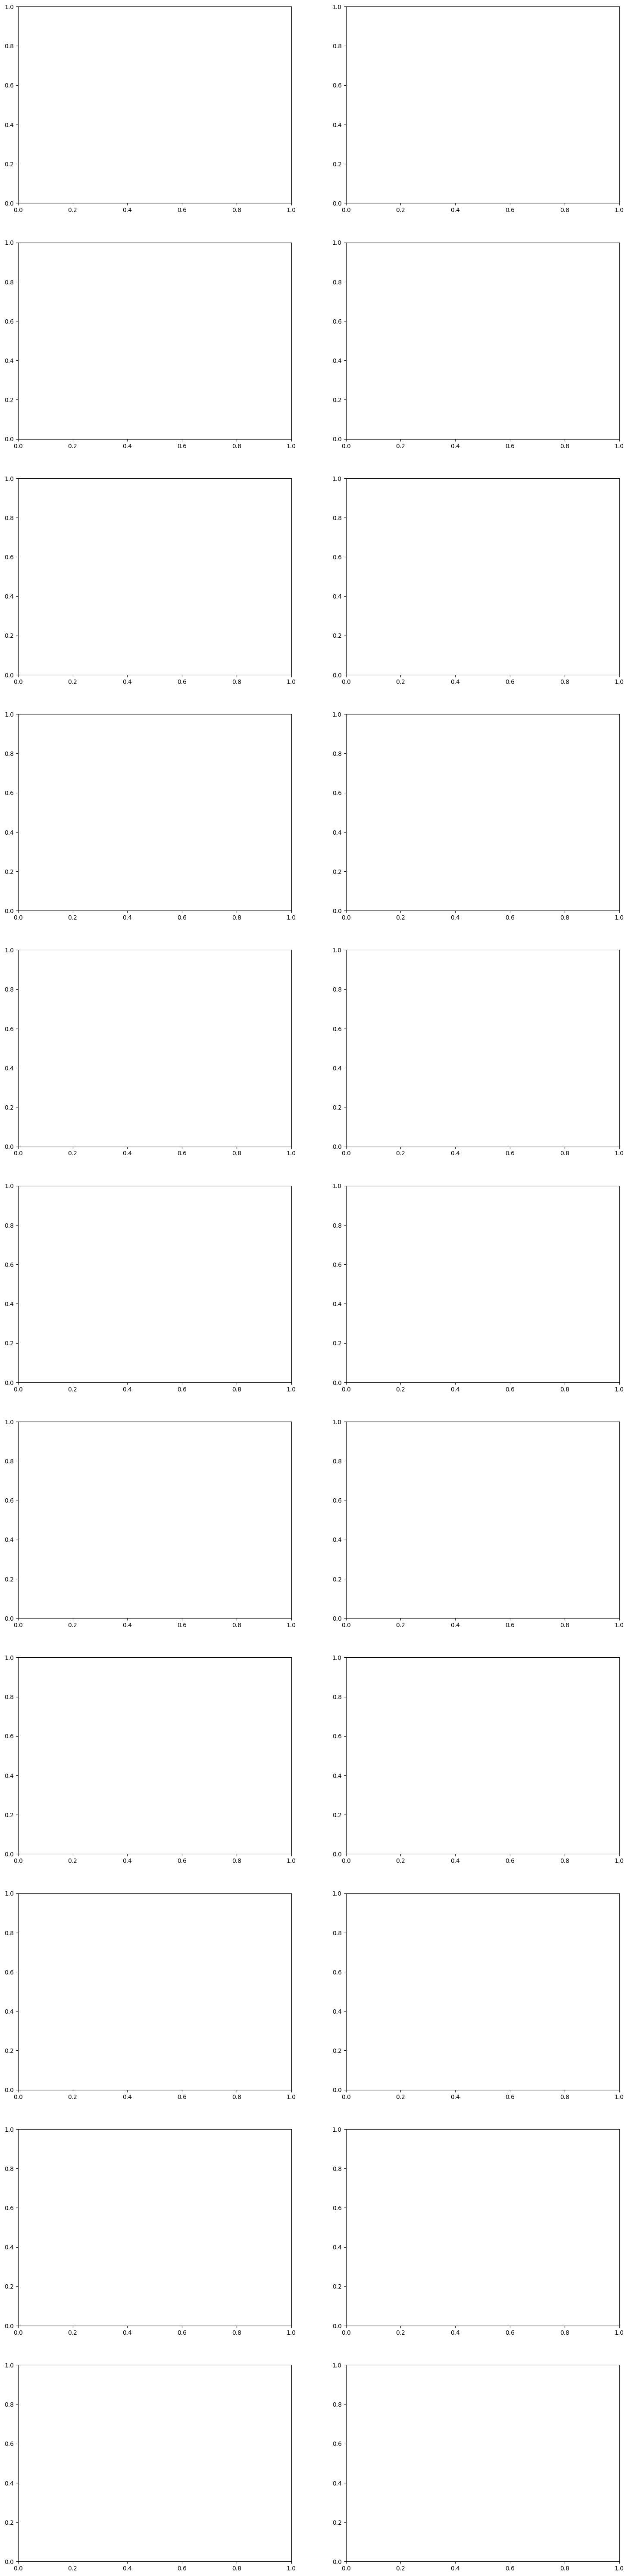

In [ ]:
# os.makedirs('plots_umap_noise', exist_ok=True)
# plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh0_normal', noise=True, save_path='plots_umap_noise/carla_veh0_normal.png')
# plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh1_aggressive', noise=True, save_path='plots_umap_noise/carla_veh1_aggressive.png')

In [154]:
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y', 'gyro_z'], ids, save_path='plots_umap/carla_gyro.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [156]:
plot_umap_uah_compare(sumo, df_acc, ['acc_x', 'acc_y'], ids, save_path='plots_umap/sumo_acc.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [155]:
plot_umap_uah_compare(sumo, df_acc, ['acc_x', 'acc_y', 'gyro_z'], ids, save_path='plots_umap/sumo_gyro.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/